In [2]:
from ultralytics import YOLO
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
import pandas as pd
import os

In [ ]:
!kaggle competitions download -c spbu-dl-2024-people-detection -p /datasets 

## SSD (Single Shot MultiBox Detector)

SSD выполняет детекцию объектов за один проход через сеть

Многоуровневая детекция (MultiBox): SSD использует несколько слоев для предсказания объектов. Каждый слой отвечает за детекцию объектов определенного масштаба. Это позволяет сети эффективно обнаруживать объекты разных размеров.

Сеточная структура: Изображение делится на сетку, и для каждой ячейки сетки сеть предсказывает ограничивающие рамки (bounding boxes) и вероятности классов объектов. Это позволяет сети одновременно предсказывать несколько объектов в разных частях изображения.

Регрессия и классификация: SSD обучается предсказывать смещения для якорей, чтобы они лучше соответствовали объектам, и классифицировать содержимое рамок. Это достигается с помощью двух выходных слоев: один для регрессии координат рамок, другой для классификации объектов.

Потеря (Loss Function): SSD использует комбинированную функцию потерь, которая включает в себя потери классификации (например, кросс-энтропия) и потери регрессии (например, Smooth L1 loss) для координат рамок.

 Немаксимальное подавление (Non-Maximum Suppression, NMS): После предсказания рамок и классов применяется NMS для удаления избыточных рамок, оставляя только наиболее вероятные детекции.

модель загружается с весами, предварительно обученными на большом наборе данных, таком как COCO. Это позволяет использовать модель сразу для задач детекции объектов.

In [2]:
#Загрузка предобученной модели SSD
model = ssdlite320_mobilenet_v3_large(pretrained=True)
model.eval()  # Установка модели в режим оценки

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

d:\AllProjects\FaceDetector\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AllProjects\FaceDetector\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [3]:
def filter_persons(image_path):
    image = Image.open(image_path).convert("RGB")

    # Преобразование изображения в тензор и нормализация
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    # с [C, H, W] (где C — количество каналов, H — высота, W — ширина) на [1, C, H, W]
    # модели глубокого обучения обычно ожидают входные данные в виде батча (пакета) изображений 
    image_tensor = transform(image).unsqueeze(0).to(device)  # Добавляем размерность батча

    with torch.no_grad():  
        predictions = model(image_tensor)

    threshold = 0.5  # Порог для фильтрации
    boxes = predictions[0]['boxes'][predictions[0]['scores'] > threshold].cpu().numpy()
    scores = predictions[0]['scores'][predictions[0]['scores'] > threshold].cpu().numpy()
    labels = predictions[0]['labels'][predictions[0]['scores'] > threshold].cpu().numpy()

    # Фильтруем только людей
    person_boxes = []
    for box, score, label in zip(boxes, scores, labels):
        if label == 1:  # (class_id = 1 для COCO)
            person_boxes.append((box, score))
    
    return person_boxes

In [4]:
image_path = './datasets/spbu-dl-2024-people-detection/train/images/3.jpg' 

filter_persons(image_path)

[(array([     12.198,    0.065635,      486.35,      331.33], dtype=float32),
  0.96121246)]

In [5]:
def detect_people(image_path):  
    person_boxes = filter_persons(image_path)

    boxes = []
    for box, score in person_boxes:
        left, top, right, bottom = box[0], box[1], box[2], box[3]
        boxes.append((int(left), int(top), int(right), int(bottom)))
    return boxes
    
detect_people(image_path)

[(12, 0, 486, 331)]

In [6]:
# Сбор всех изображений из тестового набора
image_files = [f for f in os.listdir('./datasets/spbu-dl-2024-people-detection/test/images/') if f.endswith(('.jpg', '.png'))]
image_files.sort() 

# Создание файла submission.csv
submission_data = []
for i, image_file in enumerate(image_files):
    image_path = os.path.join('./datasets/spbu-dl-2024-people-detection/test/images/', image_file)
    bboxes = detect_people(image_path)
    submission_data.append({"ID": image_file[:-4], "bboxes": bboxes})

# Создание DataFrame и запись в CSV
df = pd.DataFrame(submission_data)
df["bboxes"] = df["bboxes"].apply(lambda x: str(x))  # Преобразуем список в строку

df.to_csv("submission_SSD.csv", index=False)

## RetinaNet 

Последовательность работы:
1. Изображение проходит через несколько сверточных слоев ResNet, которые извлекают различные уровни признаков. Эти признаки представляют собой абстрактные представления изображения, которые содержат информацию о краях, текстурах, формах и других визуальных элементах.
   - на каждом уровне сети извлекаются признаки с разной степенью детализации: от низкоуровневых (например, края и текстуры) до высокоуровневых (например, сложные формы и объекты).

2. FPN (Feature Pyramid Network) строит пирамиду признаков, которая позволяет модели использовать информацию на разных уровнях разрешения.
   - FPN объединяет признаки из разных слоев ResNet, чтобы создать более богатое и детализированное представление изображения. Это помогает модели обнаруживать объекты различных размеров и форм.

3. На каждом уровне пирамиды признаков создается сетка якорей (anchors) разного размера и соотношения сторон.

4. Для каждого якоря модель предсказывает вероятность принадлежности к определенному классу и координаты ограничивающей рамки (bounding box).
   - Это делается с помощью двух отдельных "голов" сети: одна для классификации, другая для регрессии координат.

5. Используется Focal Loss для уменьшения влияния легко классифицируемых примеров и фокусировки на более сложных.
   - Это помогает справиться с дисбалансом классов, когда фонов много, а целевых объектов мало.

6. Применяется Non-Maximum Suppression, NMS для удаления избыточных рамок, оставляя только наиболее вероятные детекции.

"backbone" относится к основной части нейронной сети, которая используется для извлечения признаков из входных данных, таких как изображения. 

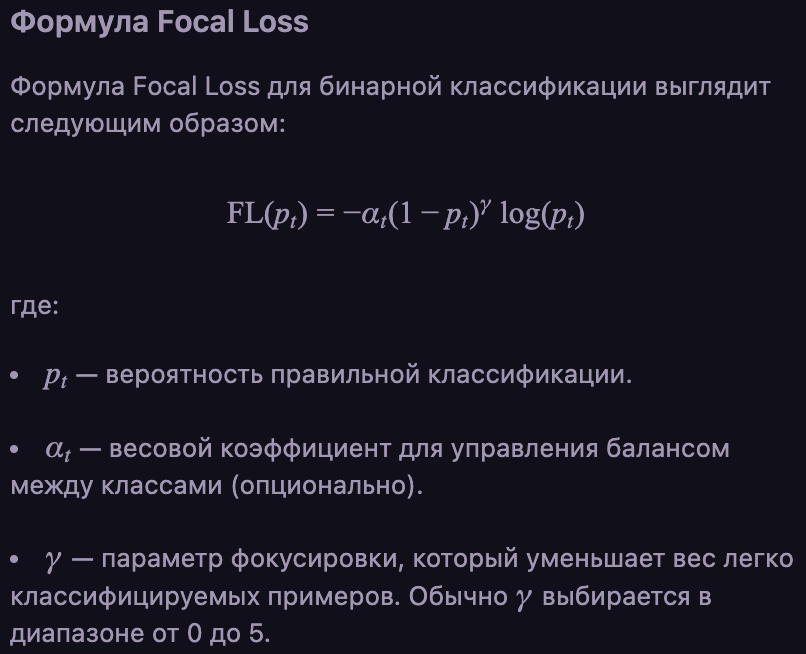

ResNet

разработанная для решения проблемы исчезающего градиента

Основная идея ResNet заключается в использовании остаточных связей (skip connections)

Основной строительный блок ResNet — это остаточный блок, который включает в себя прямую связь (skip connection) между входом и выходом блока.

Каждый остаточный блок состоит из нескольких сверточных слоев, обычно двух или трех, и прямой связи, которая добавляет вход блока к его выходу.

In [ ]:
# Загрузка предобученной модели RetinaNet
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()  # Установка модели в режим оценки

In [70]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def filter_persons(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device) 

    with torch.no_grad():  
        predictions = model(image_tensor)

    threshold = 0.5  # Порог для фильтрации
    boxes = predictions[0]['boxes'][predictions[0]['scores'] > threshold].cpu().numpy()
    scores = predictions[0]['scores'][predictions[0]['scores'] > threshold].cpu().numpy()
    labels = predictions[0]['labels'][predictions[0]['scores'] > threshold].cpu().numpy()

    person_boxes = []
    for box, score, label in zip(boxes, scores, labels):
        if label == 1:  # Класс "человек" в COCO
            person_boxes.append((box, score))
    return person_boxes

d:\AllProjects\FaceDetector\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AllProjects\FaceDetector\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
image_path = './datasets/spbu-dl-2024-people-detection/train/images/3.jpg'  # Укажите путь к вашему изображению

person_boxes = filter_persons(image_path)

for box, score in person_boxes:
    print(f"Box: {box}, Score: {score}")

print(person_boxes)

Box: [     11.272      2.6813      497.31      329.74], Score: 0.91531902551651
[(array([     11.272,      2.6813,      497.31,      329.74], dtype=float32), 0.915319)]


In [72]:
def detect_people(image_path):  
    person_boxes = filter_persons(image_path)

    boxes = []
    for box, score in person_boxes:
        left, top, right, bottom = box[0], box[1], box[2], box[3]
        boxes.append((int(left), int(top), int(right), int(bottom)))
    return boxes
    
detect_people(image_path)

[(11, 2, 497, 329)]

In [73]:
# Сбор всех изображений из тестового набора
image_files = [f for f in os.listdir('./datasets/spbu-dl-2024-people-detection/test/images/') if f.endswith(('.jpg', '.png'))]
image_files.sort()  

# Создание файла submission.csv
submission_data = []
for i, image_file in enumerate(image_files):
    image_path = os.path.join('./datasets/spbu-dl-2024-people-detection/test/images/', image_file)
    bboxes = detect_people(image_path)
    submission_data.append({"ID": image_file[:-4], "bboxes": bboxes})

# Создание DataFrame и запись в CSV
df = pd.DataFrame(submission_data)
df["bboxes"] = df["bboxes"].apply(lambda x: str(x))  # Преобразуем список в строку

df.to_csv("submission_retinanet.csv", index=False)

Submission file saved to submission1.csv


## YOLO V9

использует улучшенную архитектуру backbone для извлечения признаков из изображения

Backbone сети извлекает признаки, которые представляют собой абстрактные представления изображения, содержащие информацию о краях, текстурах и формах.

Изображение делится на сетку, и для каждой ячейки сетки сеть предсказывает ограничивающие рамки (bounding boxes) и вероятности классов объектов.

предсказывает классы и координаты объектов одновременно, используя выходные слои сети.

Применяется немаксимальное подавление (Non-Maximum Suppression, NMS)

Модель возвращает координаты ограничивающих рамок и вероятности классов для каждого обнаруженного объекта.

In [3]:
# Загрузка предобученной YOLO модели
model = YOLO('yolov9e.pt')

def filter_persons(results):
    filtered_results = []
    for result in results:
        person_boxes = [box for box in result.boxes if int(box.cls) == 0]  # Класс "person" в COCO
        result.boxes = person_boxes
        filtered_results.append(result)
    return filtered_results

In [4]:
image_path = './datasets/spbu-dl-2024-people-detection/train/images/3.jpg' 
results = model(image_path)

results = filter_persons(results)я


image 1/1 d:\AllProjects\Neuro\datasets\spbu-dl-2024-people-detection\train\images\3.jpg: 448x640 1 person, 158.0ms
Speed: 138.3ms preprocess, 158.0ms inference, 344.5ms postprocess per image at shape (1, 3, 448, 640)


array([[[ 49,  83,  99],
        [ 49,  83,  99],
        [133,  67,  61],
        ...,
        [255,  42,   4],
        [255,  42,   4],
        [126,  38,  36]],

       [[ 49,  83,  99],
        [119,  69,  66],
        [255,  42,   4],
        ...,
        [255,  42,   4],
        [255,  42,   4],
        [255,  42,   4]],

       [[ 49,  83,  99],
        [ 92,  75,  78],
        [255,  42,   4],
        ...,
        [255,  42,   4],
        [255,  42,   4],
        [255,  42,   4]],

       ...,

       [[198, 191, 206],
        [204, 197, 212],
        [203, 191, 209],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[192, 188, 200],
        [201, 194, 207],
        [201, 190, 206],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[191, 187, 198],
        [201, 195, 206],
        [202, 191, 207],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [5]:
def detect_people(image_path):
    results = model(image_path)  # Выполняем предсказание
    boxes = []
    for box in results[0].boxes:
        if int(box.cls) == 1:  
            left, top, right, bottom = box.xyxy[0].tolist()
            boxes.append((int(left), int(top), int(right), int(bottom)))
    return boxes

In [6]:
detect_people(image_path)


image 1/1 d:\AllProjects\Neuro\datasets\spbu-dl-2024-people-detection\train\images\3.jpg: 448x640 1 person, 153.0ms
Speed: 4.0ms preprocess, 153.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


[(3, 1, 498, 325)]

In [7]:
# Сбор всех изображений из тестового набора
image_files = [f for f in os.listdir('./datasets/spbu-dl-2024-people-detection/test/images/') if f.endswith(('.jpg', '.png'))]
image_files.sort()  

# Создание файла submission.csv
submission_data = []
for i, image_file in enumerate(image_files):
    image_path = os.path.join('./datasets/spbu-dl-2024-people-detection/test/images/', image_file)
    bboxes = detect_people(image_path)
    submission_data.append({"ID": image_file[:-4], "bboxes": bboxes})

# Создание DataFrame и запись в CSV
df = pd.DataFrame(submission_data)
df["bboxes"] = df["bboxes"].apply(lambda x: str(x))  # Преобразуем список в строку
df.to_csv("submission_yolo9.csv", index=False) # submission1.csv


image 1/1 d:\AllProjects\Neuro\datasets\spbu-dl-2024-people-detection\test\images\100.jpg: 480x640 10 persons, 1 bird, 168.0ms
Speed: 2.0ms preprocess, 168.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 d:\AllProjects\Neuro\datasets\spbu-dl-2024-people-detection\test\images\1000.jpg: 640x512 (no detections), 150.0ms
Speed: 4.0ms preprocess, 150.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 d:\AllProjects\Neuro\datasets\spbu-dl-2024-people-detection\test\images\1006.jpg: 640x640 (no detections), 209.0ms
Speed: 4.0ms preprocess, 209.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\AllProjects\Neuro\datasets\spbu-dl-2024-people-detection\test\images\1007.jpg: 640x512 1 person, 2 couchs, 146.0ms
Speed: 3.0ms preprocess, 146.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 d:\AllProjects\Neuro\datasets\spbu-dl-2024-people-detection\test\images\1009.jpg: 544x64